In [75]:
import cv2
from matplotlib import pyplot as plt
import os
from os import path
import re
import numpy as np
import shutil
import math
from scipy.special import softmax

In [168]:
BASE_DIR = '/data3/lyf/MVSNET/mvsnet_test/results/illumination_part1_adaptives/'
NUM_VIEW = 5
MAX_H = 864
MAX_W = 1152
%matplotlib inline

In [178]:
groups = list(os.scandir(BASE_DIR))
demo_group = groups[0]

In [179]:
files = list(os.scandir(demo_group))

In [180]:
print(demo_group.path)

/data3/lyf/MVSNET/mvsnet_test/results/illumination_part1_adaptives/99


In [181]:
def scale_and_crop_label(label, max_h, max_w):
    """ must resemble the behavior in mvsnet preprocessing, see dataflow_utils.py for details"""
    # scale to max scale, avoid padding
    h, w = label.shape
    height_scale = max_h / h
    width_scale = max_w / w
    resize_scale = max(height_scale, width_scale)
    assert height_scale < 1 and width_scale < 1, 'max_h, max_w shall be less than h, w'
    label = cv2.resize(label, None, fx=resize_scale, fy=resize_scale, interpolation=cv2.INTER_NEAREST)
    
    # then crop
    h, w = label.shape
    new_h = min(h, max_h)
    new_w = min(w, max_w)
    start_h = int(math.ceil((h - new_h) / 2))
    start_w = int(math.ceil((w - new_w) / 2))
    print(new_h, new_w)
    return label[start_h: start_h + new_h, start_w: start_w + new_w]

uint8 (864, 1152, 3)
float32 (864, 1152)
float32 (184, 216, 288)
uint8 (3811, 6000)
864 1152
uint8 (864, 1152)


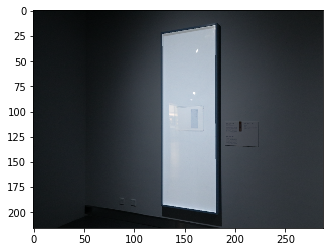

In [182]:
for i in range(NUM_VIEW)[:1]:
    # h, w, 3
    img = cv2.imread(path.join(demo_group.path, '{}_rgb.png'.format(i)))
    print(img.dtype, img.shape)
    
    # h, w (upsampled)
    depth = cv2.imread(path.join(demo_group.path, '{}_depth.exr'.format(i)), cv2.IMREAD_UNCHANGED)
    print(depth.dtype, depth.shape)
    # d, h/4, w/4
    reg_cost_volume = np.load(path.join(demo_group.path, '{}reg_cost_volume.npz.npy'.format(i)))
    print(reg_cost_volume.dtype, reg_cost_volume.shape)
    
    label = cv2.imread(path.join(demo_group.path, '{}_label.png'.format(i)), cv2.IMREAD_GRAYSCALE)
    print(label.dtype, label.shape)
    label = scale_and_crop_label(label, MAX_H, MAX_W)
    print(label.dtype, label.shape)
    # check if the label aligns the img
    fused_img = (0.5 * img + 0.5 * np.tile(np.expand_dims(label, axis=-1), [1, 1, 3])).astype('uint8')
    fused_img = cv2.resize(fused_img, None, fx=0.25, fy=0.25)
    plt.imshow(fused_img)
    
    downsample_label = cv2.resize(label, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_NEAREST)
    
    ## extract the illuminated part
    mask = np.where(downsample_label == 0, np.zeros_like(reg_cost_volume), np.ones_like(reg_cost_volume))
    
    masked_cost_volume = reg_cost_volume * mask
    

In [183]:
masked_cost_volume.shape

(184, 216, 288)

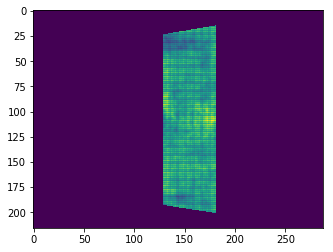

In [184]:
plt.imshow(masked_cost_volume[2])

## explore the feature

In [71]:
## pixel wise, depth wise

### depth wise

In [230]:
feature = np.sum(masked_cost_volume, axis=(1, 2))

In [231]:
feature.shape

(184,)

<BarContainer object of 184 artists>

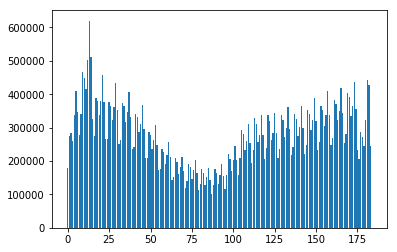

In [232]:
plt.bar(range(len(feature)), feature)

### pixel wise

In [233]:
feature = reg_cost_volume[..., 50, 140]

In [234]:
feature.shape

(184,)

<BarContainer object of 184 artists>

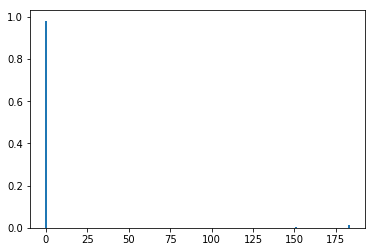

In [235]:
plt.bar(range(len(feature)), softmax(-feature))

<BarContainer object of 184 artists>

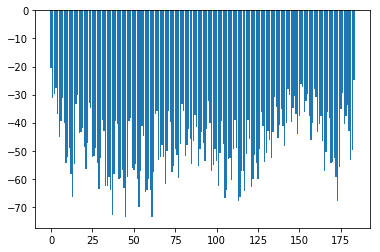

In [236]:
plt.bar(range(len(feature)), -feature)

In [225]:
max(softmax(-feature))

0.9817269

In [226]:
math.exp(57)
math.exp(51)

1.4093490824269389e+22

In [228]:
list(reversed(sorted(softmax(-feature))))


[0.9817269,
 0.0117221875,
 0.0031250028,
 0.0009597541,
 0.00086477806,
 0.0005044706,
 0.0004645416,
 0.00012332297,
 0.00010650711,
 0.00010159452,
 6.788779e-05,
 5.8480196e-05,
 3.8612598e-05,
 3.5235444e-05,
 2.934848e-05,
 2.425272e-05,
 1.9612002e-05,
 6.737847e-06,
 6.302251e-06,
 3.4393868e-06,
 2.6722491e-06,
 2.187175e-06,
 1.9839765e-06,
 8.9015737e-07,
 5.4619073e-07,
 5.2110727e-07,
 4.5883118e-07,
 4.4096421e-07,
 2.4318751e-07,
 2.0504628e-07,
 1.9815023e-07,
 1.605588e-07,
 1.3120334e-07,
 1.3013315e-07,
 6.898018e-08,
 6.198387e-08,
 6.132767e-08,
 5.2638146e-08,
 3.5807883e-08,
 3.2429917e-08,
 3.0502065e-08,
 3.0402976e-08,
 2.0129589e-08,
 1.517891e-08,
 8.870312e-09,
 8.148243e-09,
 7.4290285e-09,
 7.1832598e-09,
 6.0040595e-09,
 5.202864e-09,
 5.1204623e-09,
 4.7078608e-09,
 4.64404e-09,
 3.372639e-09,
 3.3127223e-09,
 2.9644347e-09,
 2.4765283e-09,
 2.4343971e-09,
 2.1026443e-09,
 1.8076625e-09,
 1.3783167e-09,
 1.1809532e-09,
 9.335982e-10,
 8.587956e-10,
 7.2

In [229]:
list(reversed(sorted((-feature))))

[-20.501469,
 -24.929298,
 -26.251347,
 -27.43186,
 -27.536064,
 -28.075027,
 -28.157486,
 -29.48373,
 -29.630325,
 -29.677547,
 -30.08068,
 -30.229849,
 -30.644958,
 -30.736485,
 -30.919296,
 -31.110008,
 -31.322395,
 -32.390797,
 -32.45763,
 -33.063244,
 -33.315617,
 -33.515926,
 -33.613434,
 -34.414894,
 -34.903324,
 -34.950336,
 -35.07761,
 -35.11733,
 -35.71246,
 -35.883057,
 -35.917267,
 -36.127632,
 -36.329544,
 -36.337734,
 -36.972473,
 -37.07942,
 -37.09006,
 -37.24285,
 -37.628124,
 -37.72721,
 -37.788498,
 -37.79175,
 -38.2041,
 -38.486385,
 -39.023582,
 -39.10849,
 -39.200897,
 -39.23454,
 -39.413857,
 -39.557083,
 -39.573048,
 -39.65706,
 -39.670708,
 -39.990597,
 -40.008522,
 -40.119606,
 -40.299435,
 -40.316593,
 -40.463097,
 -40.614258,
 -40.88543,
 -41.03997,
 -41.275,
 -41.358517,
 -41.526295,
 -42.06684,
 -42.209213,
 -42.334633,
 -42.892876,
 -42.934086,
 -43.11558,
 -43.205994,
 -43.312077,
 -43.404476,
 -43.49201,
 -43.599243,
 -44.01646,
 -44.657333,
 -45.033665,

In [103]:
max(feature)

53.11943

In [104]:
min(feature)

6.3661423

In [105]:
sum(feature)

4294.255581855774

In [106]:
softmax(feature)

array([4.91668298e-19, 1.31254042e-16, 1.69657192e-16, 1.74714482e-16,
       1.19408322e-13, 1.17782131e-10, 5.80750237e-13, 8.53494860e-14,
       8.96687169e-11, 2.29923629e-07, 4.54530369e-09, 1.59404290e-09,
       1.18659809e-05, 9.99668181e-01, 4.95045970e-06, 1.99205201e-11,
       2.87927234e-14, 2.92303473e-11, 8.99986856e-12, 2.38608807e-12,
       2.72453310e-10, 5.59515314e-08, 3.96512657e-13, 5.12254398e-16,
       1.67446767e-15, 4.85069580e-12, 1.03031732e-12, 1.19082912e-12,
       5.05453401e-10, 2.15348251e-07, 9.34320004e-13, 9.31419597e-17,
       2.83602285e-18, 9.89439832e-16, 8.61301164e-16, 7.70747466e-15,
       5.33186169e-11, 3.60359707e-08, 1.92021442e-12, 1.54178006e-15,
       4.16498012e-16, 2.94328987e-13, 5.54682067e-14, 2.50858009e-13,
       4.64645628e-10, 2.50573777e-07, 8.72656548e-12, 6.35234180e-15,
       3.97766630e-15, 4.43042911e-12, 3.18049488e-13, 1.37854260e-13,
       2.38748799e-10, 1.61068272e-07, 1.20309865e-11, 1.11712279e-14,
      